***1. Installing Dependencies***


In [1]:
!pip install transformers
!pip install torch torchvision torchaudio
!pip install scikit-learn
!pip install seaborn
!pip install matplotlib

***2. Import Libraries like Torch, Pandas, Numpy etc...***

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from transformers import BertTokenizer,BertForSequenceClassification, BertModel, get_linear_schedule_with_warmup
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict



***3️. Set device random seed and Type of device available either CPU or GPU***

In [3]:
RANDOM_SEED = 42
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


***4. To upload CSV file from Your device to Google collab***

In [ ]:
# from google.colab import files

# uploaded = files.upload()  # choose review.csv. from your computer


***5. To load reviews, keep score and text, convert scores into sentiment labels (negative/neutral/positive), clean nulls, and show data summary***

In [5]:
import pandas as pd

# Load CSV
df = pd.read_csv("Reviews1.csv")

# Keep only useful columns
df = df[['Score', 'Text']]

# Map Score → Sentiment
def score_to_sentiment(score):
    if score <= 2:
        return "negative"
    elif score == 3:
        return "neutral"
    else:
        return "positive"

df['Sentiment'] = df['Score'].apply(score_to_sentiment)

# Drop nulls
df = df.dropna(subset=['Text'])

print(df.head())
print(df['Sentiment'].value_counts())


   Score                                               Text Sentiment
0      5  I have bought several of the Vitality canned d...  positive
1      1  Product arrived labeled as Jumbo Salted Peanut...  negative
2      4  This is a confection that has been around a fe...  positive
3      2  If you are looking for the secret ingredient i...  negative
4      5  Great taffy at a great price.  There was a wid...  positive
Sentiment
positive    7615
negative    1522
neutral      862
Name: count, dtype: int64


***6. To import the os module and list all files/folders in the current working directory***

In [6]:
import os
print(os.listdir())  # check what files are in your working dir


['.config', 'Reviews.csv', 'Reviews1.csv', 'sample_data']


***7. To load the Reviews1.csv file into a DataFrame and print its shape (rows × columns) along with the column names***

In [7]:
import pandas as pd

df = pd.read_csv("Reviews1.csv")   # must match exact filename!
print(df.shape)
print(df.columns)


(9999, 10)
Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')


***8. To prepare a clean and balanced dataset by converting review scores into sentiment labels and undersampling classes to make them equal***

In [8]:
print("Shape before cleaning:", df.shape)
print("Null counts:\n", df[['Score', 'Text']].isnull().sum())
print("Unique scores:", df['Score'].unique()[:20])  # check score values
print(df.head())
# Keep only needed columns
df = df[['Score', 'Text']].dropna()

# Map Score → Sentiment
def score_to_sentiment(score):
    if score <= 2:
        return 0   # negative
    elif score == 3:
        return 1   # neutral
    else:
        return 2   # positive

df['Sentiment'] = df['Score'].apply(score_to_sentiment)

# Check class distribution
print("Class distribution before balancing:")
print(df['Sentiment'].value_counts())

# Find smallest class size
min_count = df['Sentiment'].value_counts().min()
print("Smallest class size:", min_count)

# Balance dataset → use min_count for all classes
df = (
    df.groupby("Sentiment", group_keys=False)
      .apply(lambda x: x.sample(n=min_count, random_state=42))
      .reset_index(drop=True)
)

print("\nClass distribution after balancing:")
print(df['Sentiment'].value_counts())
print(df.shape)  # should be (min_count * 3, 3)


Shape before cleaning: (9999, 10)
Null counts:
 Score    0
Text     0
dtype: int64
Unique scores: [5 1 4 2 3]
   Id   ProductId          UserId                      ProfileName  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1   2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2   3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   
3   4  B000UA0QIQ  A395BORC6FGVXV                             Karl   
4   5  B006K2ZZ7K  A1UQRSCLF8GW1T    Michael D. Bigham "M. Wassir"   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     1                       1      5  1303862400   
1                     0                       0      1  1346976000   
2                     1                       1      4  1219017600   
3                     3                       3      2  1307923200   
4                     0                       0      5  1350777600   

                 Summary                        

/tmp/ipython-input-2592146258.py:30: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=min_count, random_state=42))


**9. To create a balanced dataset by undersampling each sentiment class to the size of the smallest class So that the dataset remain balanced  to prevent bias and make your sentiment classifier more accurate across all classes**

In [9]:
# Check smallest class size
min_count = df['Sentiment'].value_counts().min()
print("Smallest class size:", min_count)

# Balance dataset safely
df_balanced = (
    df.groupby("Sentiment", group_keys=False)
      .apply(lambda x: x.sample(n=min_count, random_state=42))
      .reset_index(drop=True)
)

print(df_balanced['Sentiment'].value_counts())
print(df_balanced.shape)


Smallest class size: 862
Sentiment
0    862
1    862
2    862
Name: count, dtype: int64
(2586, 3)


/tmp/ipython-input-2273633542.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=min_count, random_state=42))


***10. Split the dataset into training (80%) and validation (20%) sets so the model can learn on one part and be tested on unseen data***

In [10]:
from sklearn.model_selection import train_test_split

texts = df["Text"].values
labels = df["Sentiment"].values

train_texts, val_texts, train_labels, val_labels = train_test_split(
    texts, labels, test_size=0.2, random_state=42
)

print(len(train_texts), len(val_texts))  # should be 24000 / 6000


2068 518


***11. Convert sentiments into numbers and split the data into train, validation, and test parts***

In [11]:
class_names = ["positive", "negative", "neutral"]
label_dict = {label: idx for idx, label in enumerate(class_names)}
df['label'] = df['Sentiment'].map(label_dict)

# Split dataset
df_train, df_test = train_test_split(df, test_size=0.2, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)
print(df_train.shape, df_val.shape, df_test.shape)

(2068, 4) (259, 4) (259, 4)


***12. To import a BERT tokenizer and convert the training and validation texts into token IDs with padding and truncation for model input***

In [12]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

train_encodings = tokenizer(list(train_texts), truncation=True, padding=True, max_length=128)
val_encodings = tokenizer(list(val_texts), truncation=True, padding=True, max_length=128)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

***13. To wrap tokenized texts and labels into a PyTorch dataset class so that it can be fed into the model during training and validation***

In [13]:
class SentimentDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

train_dataset = SentimentDataset(train_encodings, train_labels)
val_dataset = SentimentDataset(val_encodings, val_labels)

***14. Using a pre-trained BERT model and preparing it for 3-class sentiment classification on your device***

In [14]:
from transformers import BertForSequenceClassification

# Define number of labels (3 = negative, neutral, positive)
num_labels = 3

model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=num_labels,
    id2label={0: "negative", 1: "neutral", 2: "positive"},
    label2id={"negative": 0, "neutral": 1, "positive": 2}
)
model.to(device)


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

*15. Prepare the test dataset so the model can process it in small batches during evaluation*

In [15]:
# Batch size (commonly 16, 32, or 64 depending on GPU memory)
BATCH_SIZE = 16
# Extract test texts
test_texts = df_test["Text"].values  # df_test = your test DataFrame

# Tokenize test texts using the same tokenizer
test_encodings = tokenizer(list(test_texts), truncation=True, padding=True, max_length=128)

# Prepare labels if available (for evaluation); skip if just predicting
test_labels = df_test["Sentiment"].values  # optional

# Create DataLoader for test set
test_dataset = SentimentDataset(test_encodings, test_labels)
test_data_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)


***16. To prepare training and validation datasets so the model can process them in small batches efficiently***

In [16]:
# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)

***17. To set up optimizer and learning rate scheduler so the model can train efficiently and update weights properly***

In [17]:
optimizer = AdamW(model.parameters(), lr=5e-5)
epochs = 3
total_steps = len(train_loader) * epochs

scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=0, num_training_steps=total_steps
)

*18. To convert all test texts into fixed-length BERT token tensors ready for model prediction*

In [18]:
# Max token length (commonly 128, 256, or 512 depending on dataset and GPU memory)
MAX_LEN = 128

# Encode test dataset
test_encodings = tokenizer(
    df_test.Text.to_list(),
    truncation=True,
    padding=True,
    max_length=MAX_LEN,
    return_tensors="pt"
)


***19. The train_epoch function trains the model on the training data for one pass and returns the accuracy and loss. The eval_model function checks how well the model performs on validation or test data without changing the weights. Before training or testing, texts are converted into BERT inputs and grouped into batches using a DataLoader. Finally, get_predictions collects the model’s predicted labels, probabilities, and true labels for evaluation and analysis.***

In [19]:
# Training & Evaluation Functions

def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model.train()
    losses = []
    correct_predictions = 0

    for d in data_loader:
        input_ids = d['input_ids'].to(device)
        attention_mask = d['attention_mask'].to(device)
        targets = d['labels'].to(device, dtype=torch.long)

        # Forward pass
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits  # ✅ get logits from model output

        _, preds = torch.max(logits, dim=1)
        loss = loss_fn(logits, targets)

        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()

    return correct_predictions.double() / n_examples, np.mean(losses)


def eval_model(model, data_loader, loss_fn, device, n_examples):
    model.eval()
    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for d in data_loader:
            input_ids = d['input_ids'].to(device)
            attention_mask = d['attention_mask'].to(device)
            targets = d['labels'].to(device, dtype=torch.long)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits  # ✅

            _, preds = torch.max(logits, dim=1)
            loss = loss_fn(logits, targets)

            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())

    return correct_predictions.double() / n_examples, np.mean(losses)

# Encode test dataset
test_encodings = tokenizer(
    df_test.Text.to_list(),
    truncation=True,
    padding=True,
    max_length=MAX_LEN,
    return_tensors="pt"
)

test_dataset = SentimentDataset(test_encodings, df_test.Sentiment.to_list())

from torch.utils.data import DataLoader
test_data_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)


def get_predictions(model, data_loader, device):
    model.eval()
    review_texts = []
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:
            # If your dataset doesn't include 'review_text', remove this line
            texts = d.get('review_text', [""] * len(d['labels']))

            input_ids = d['input_ids'].to(device)
            attention_mask = d['attention_mask'].to(device)
            targets = d['labels'].to(device, dtype=torch.long)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits  # ✅

            _, preds = torch.max(logits, dim=1)

            review_texts.extend(texts)
            predictions.extend(preds.cpu())
            prediction_probs.extend(logits.cpu())
            real_values.extend(targets.cpu())

    return review_texts, torch.stack(predictions), torch.stack(prediction_probs), torch.stack(real_values)


***20. To compute the model’s predictions, probabilities, and true labels for the entire dataset efficiently, batch by batch, without updating weights***

In [20]:
def get_predictions(model, data_loader, device):
    model.eval()
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            labels = d["labels"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            probs = torch.nn.functional.softmax(outputs.logits, dim=1)
            _, preds = torch.max(probs, dim=1)

            predictions.append(preds.cpu())
            prediction_probs.append(probs.cpu())
            real_values.append(labels.cpu())

    # Concatenate all batches
    predictions = torch.cat(predictions)
    prediction_probs = torch.cat(prediction_probs)
    real_values = torch.cat(real_values)

    return predictions, prediction_probs, real_values


***21. To set up the optimizer, learning rate scheduler, and loss function so the BERT model can learn efficiently and classify sentiments correctly***

In [21]:


import torch.nn as nn

# Optimizer
optimizer = AdamW(model.parameters(), lr=2e-5)

# Scheduler
total_steps = len(train_loader) * epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

# Loss function
loss_fn = nn.CrossEntropyLoss().to(device)


***22. Train the BERT model over multiple epochs, track accuracy/loss, evaluate on validation set, and save the best model***

In [22]:
# Training Loop
# Train model for given number of epochs and save best version
history = defaultdict(list)
best_accuracy = 0

for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    print("-"*10)

    train_acc, train_loss = train_epoch(model, train_loader, loss_fn, optimizer, device, scheduler, len(df_train))
    print(f"Train loss {train_loss} accuracy {train_acc}")

    val_acc, val_loss = eval_model(model, val_loader, loss_fn, device, len(df_val))
    print(f"Val   loss {val_loss} accuracy {val_acc}\n")

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    # Save best model
    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_accuracy = val_acc


Epoch 1/3
----------
Train loss 0.9101671824088463 accuracy 0.562862669245648
Val   loss 0.6695952912171682 accuracy 1.393822393822394

Epoch 2/3
----------
Train loss 0.5775613069534302 accuracy 0.7678916827852998
Val   loss 0.6334938343727228 accuracy 1.4401544401544402

Epoch 3/3
----------
Train loss 0.3747751333392583 accuracy 0.8728239845261122
Val   loss 0.6541986077120809 accuracy 1.471042471042471



***23. Evaluate the model by showing classification metrics and a confusion matrix for the test set predictions***

/tmp/ipython-input-3453313822.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


              precision    recall  f1-score   support

    negative       0.80      0.71      0.76        98
     neutral       0.61      0.67      0.64        76
    positive       0.85      0.89      0.87        85

    accuracy                           0.76       259
   macro avg       0.76      0.76      0.76       259
weighted avg       0.76      0.76      0.76       259



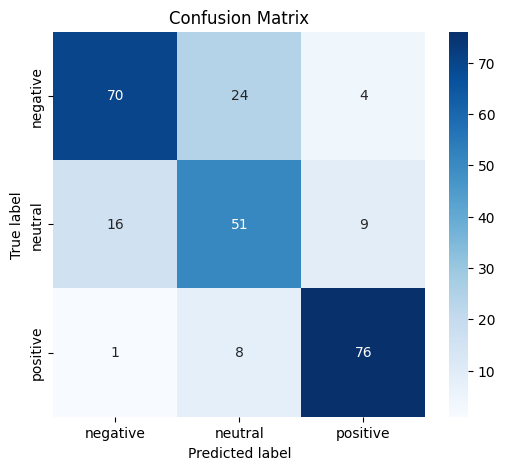

In [23]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Define class names and corresponding labels
class_names = ['negative', 'neutral', 'positive']

label_dict = {name: i for i, name in enumerate(class_names)}
labels = list(label_dict.values())

# Get predictions
# y_review_texts,
y_pred, y_pred_probs, y_test = get_predictions(model, test_data_loader, device)

# Convert predictions and true values to numpy arrays
y_pred_np = np.array([int(x) for x in y_pred])
y_test_np = np.array([int(x) for x in y_test])

# Classification report (safe even if some classes are missing in test set)
print(classification_report(
    y_test_np,
    y_pred_np,
    labels=labels,
    target_names=class_names,
    zero_division=0  # Avoid errors for missing classes
))

# Confusion matrix
cm = confusion_matrix(y_test_np, y_pred_np, labels=labels)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)

# Plot
plt.figure(figsize=(6,5))
sns.heatmap(df_cm, annot=True, fmt='d', cmap='Blues')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()


***24. Function to take a text review and predict its sentiment with confidence and class probabilities using your trained BERT model***

In [25]:
def predict_sentiment(text):
    # Encode input
    encoding = tokenizer(
        text,
        truncation=True,
        padding=True,
        max_length=MAX_LEN,
        return_tensors="pt"
    ).to(device)

    # Forward pass
    output = model(**encoding)
    logits = output.logits  # raw scores

    probs = torch.nn.functional.softmax(logits, dim=1) # Probabilities

    confidence, prediction = torch.max(probs, dim=1)
    # Return label, confidence, and all probabilities
    return class_names[prediction.item()], confidence.item(), probs.detach().cpu().numpy()

label, conf, probs = predict_sentiment(
    "I absolutely love this product! It works perfectly. "
)

print(f"Prediction: {label} ({conf:.2f} confidence)")
print("All class probabilities:", probs)

Prediction: positive (0.98 confidence)
All class probabilities: [[0.00800815 0.01422663 0.97776526]]


Product arrived labeled as Jumbo Salted Peanuts... the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as Jumbo




# Example
# print(predict_sentiment("Great taffy at a great price.  There was a wide assortment of yummy taffy. Delivery was quick. If your a taffy lover, this is a deal "))
#I absolutely love this product! It works perfectly.
#This service is terrible and disappointing